## Find Line Segment From Given Point

An implementation of the seam carving algorithm readapted to work with a given point and direction so that it finds the segmenting line on a document.
Implementation of the algorithm largely follows the implementation in the [link](https://karthikkaranth.me/blog/implementing-seam-carving-with-python/):

Author of this notebook: Kaan Eraslan

Author in the link: Karthik Karanth

## Trouver Ligne de Segmentation avec des Points

An implementation of the seam carving algorithm readapted to work with a given point and direction so that it finds the segmenting line on a document.
Implementation of the algorithm largely follows the implementation in the [link](https://karthikkaranth.me/blog/implementing-seam-carving-with-python/):

Author of this notebook: Kaan Eraslan

Author in the link: Karthik Karanth

Importing the necessary packages:

In [1]:
import os  # path manipulation
import numpy as np  # array/matrix manipulation
import scipy.ndimage as nd  # operate easily on image matrices
import matplotlib.pyplot as plt  # plotting library
import cv2  # mostly here for image io
import time # for simple benchmarking

First we need to calculate the energy of each pixel. 

Here is one way of doing it:

In [2]:
def calc_energy(img: np.ndarray([],
                                dtype=np.uint8)):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(
        nd.filters.convolve(img, filter_du)
                           ) + np.absolute(
        nd.filters.convolve(img, filter_dv)
    )

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map


Let's see the result on two images

In [3]:
fig_size = plt.rcParams["figure.figsize"] 
# Set figure width to 12 and height to 9
fig_size[0] = 21
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size


In [4]:
im1, im2 = cv2.imread('images/vietHard.jpg'), cv2.imread('images/image1nice.jpg')

Here are the original images:

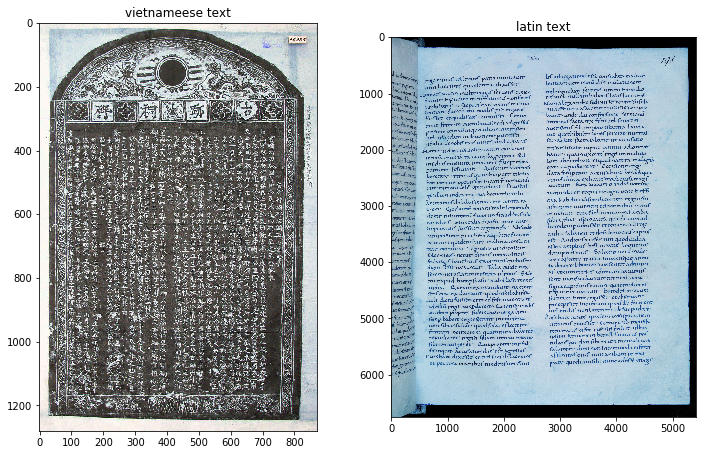

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("vietnameese text")
ax1.imshow(im1)

ax2.set_title('latin text')
ax2.imshow(im2)

plt.show()

Here is their calculated energy maps:

In [6]:
im1e, im2e = calc_energy(im1), calc_energy(im2)

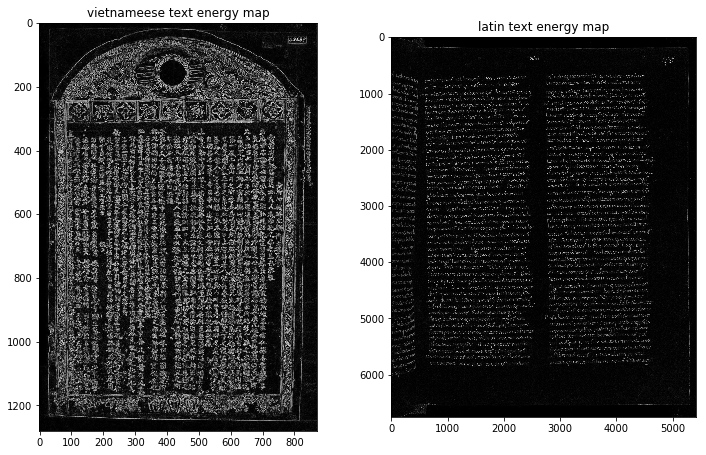

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("vietnameese text energy map")
ax1.imshow(im1e, cmap='gray')

ax2.set_title('latin text energy map')
ax2.imshow(im2e, cmap='gray')

plt.show()

Here is a side by side version for better comparison

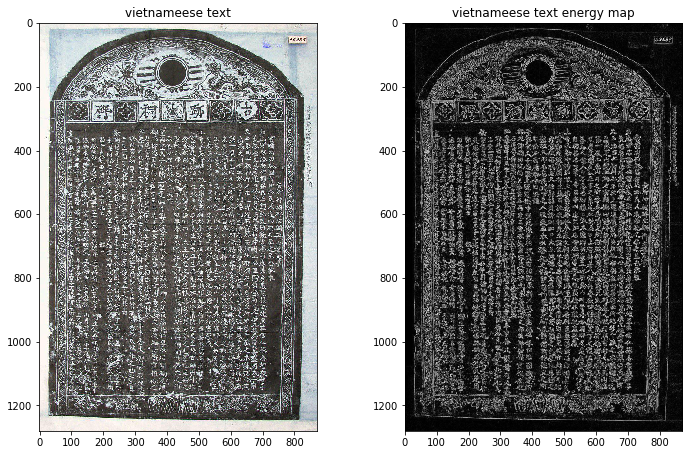

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("vietnameese text")
ax1.imshow(im1, cmap='gray')

ax2.set_title('vietnameese text energy map')
ax2.imshow(im1e, cmap='gray')

plt.show()

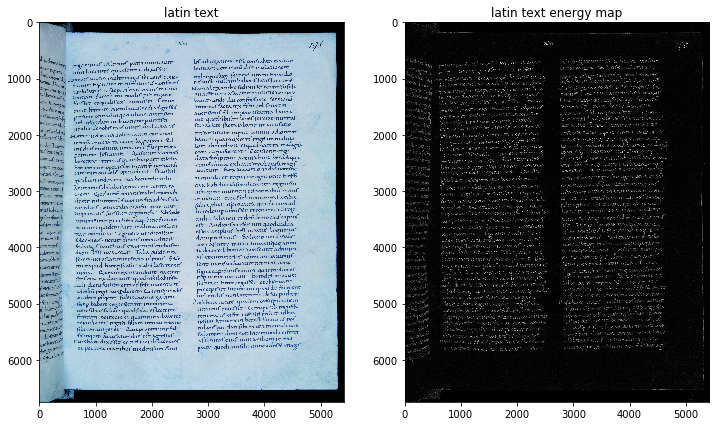

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("latin text")
ax1.imshow(im2, cmap='gray')

ax2.set_title('latin text energy map')
ax2.imshow(im2e, cmap='gray')

plt.show()

Now let's see the function for calculating the seam, ie the column with minimum energy:

In [10]:
def minimum_seam(img, emap=None):
    r, c, _ = img.shape
    
    # if the energy map is already calculated
    if emap is not None:
        energy_map = emap
    else:
        energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                maprow = M[i-1, j:j+2]
                idx = np.argmin(maprow)
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

And consequently the function that will mark the seam:

In [11]:
def mark_column(img, 
                emap=None, 
                mark_color=[250, 120, 120]  # yellow
               ):
    r, c, _ = img.shape
    imcopy = img.copy()

    M, backtrack = minimum_seam(img, emap)

    # Create a (r, c) matrix filled with the value True
    # We'll be marking all pixels from the image which
    # have False later
    mask = np.zeros((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels 
        # and save mark positions for later use
        mask[i, j] = True
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)
    
    # mark the pixels with the given mark color
    imcopy = np.where(mask, mark_color, img)
    
    return imcopy, mask

Let's arrange the function for rows as well

In [12]:
def mark_row(img, mark_color=[250,120,120]):
    img = np.rot90(img, 1, (0, 1))
    img, mask = mark_column(img, mark_color=mark_color)
    img = np.rot90(img, 3, (0, 1))
    mask = np.rot90(mask, 3, (0,1))
    return img, mask

Let's see how our functions fare out in our texts. 

Note that they return two things:
   
   - Marked image, 
   - Mask 
   
The mask and the image has the same shape. 
The only difference is that mask is filled with zeros except on positions of the mark.

In [ ]:
stime1 = time.time()
im1marked, im1mask = mark_column(im1)
etime1 = time.time()
print('duration of the operation: ', round(etime1-stime1, 5))

In [ ]:
stime2 = time.time()
im2marked, im2mask = mark_row(im2)
etime2 = time.time()
print('duration of the operation: ', round(etime2 - stime2, 5))

Let's plot our images

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("latin text with mark")
ax1.imshow(im2marked)

ax2.set_title('latin text')
ax2.imshow(im2)

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("Vietnameese text with mark")
ax1.imshow(im1marked)

ax2.set_title('vietnameese text')
ax2.imshow(im1)

plt.show()

Let's see them individually

In [ ]:
plt.imshow(im1marked)

In [ ]:
plt.imshow(im2marked)

As you can see there are several problems here:

- Marked areas are not between texts
- Runtime of the functions are too long

What if we could slice the texts into columns and lines ourselves and then try our functions ?

Let's segment the vietnameese text into a column

In [ ]:
im1slice = im1[:, 550:600]

In [ ]:
plt.imshow(im1slice)

Let's segment the latin text into a line

In [ ]:
im2slice = im2[700:1000, 500:]

In [ ]:
plt.imshow(im2slice)

Let's see how well our marking function work on our slices

In [ ]:
stime1 = time.time()
im1sliceMarked, mask1 = mark_column(im1slice, mark_color=[0,255,0])
etime1 = time.time()
print("duration of the operation: ", round(etime1-stime1, 5))

In [ ]:
stime2 = time.time()
im2sliceMarked, mask2 = mark_row(im2slice, mark_color=[0,255,0])
etime2 = time.time()
print("duration of the operation: ", round(etime2-stime2, 5))

Let's plot the results

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("latin text slice with mark")
ax1.imshow(im2sliceMarked)

ax2.set_title('vietnameese text slice with mark')
ax2.imshow(im1sliceMarked)

plt.show()

Here is each of them individualy:

In [ ]:
plt.imshow(im2sliceMarked)

In [ ]:
plt.imshow(im1sliceMarked)

This is not so bad. 

The runtime is lowered significantly, and we can see that the functions clearly mark the zones between texts. 

However slicing individually for each column or line is not really convinient.

It would be better if we could just select a point, a direction for the marking function, and the width/height of the sliced area.

We don't need to be so precise with our selection since the marking function would figure out a reasonable path anyway.

We need two functions, one that expands the point coordinate for the determined amount of slicing, and a function that does the actual slicing with given amount

In [13]:
def expandPointCoordinate(ubound: int,
                          coord: int,
                          thresh: int):
    "Expand the coordinate with ubound using given threshold"
    assert thresh <= 100 and thresh > 0
    assert isinstance(thresh, int) == True
    sliceAmount = ubound * thresh // 100
    sliceHalf = sliceAmount // 2
    coordBefore = coord - sliceHalf
    coordAfter = coord + sliceHalf
    if coordBefore < 0:
        coordBefore = 0
    if coordAfter >= ubound:
        coordAfter = ubound - 1
    return coordBefore, coordAfter

def sliceOnPoint(img: np.ndarray([], dtype=np.uint8),
                 point: (int, int),
                 colSlice=True,
                 isUpTo=False,
                 thresh=10) -> np.ndarray([], dtype=np.uint8):
    """
    Slice based on the point with given threshold as percent
    
    Description
    ------------
    We take the point as a center. Then we calculate
    the amount of slicing based on the threshold.
    Threshold is a percent value. Thus the sliced amount
    is relative to the image shape.
    Once the slicing amount is computed, we slice the given
    amount from the image. The point should be at the center
    of a side of the sliced area.
    
    Parameters
    ------------
    img: np.ndarray([], dtype=np.uint8)
    point: (int, int) 
        coordinate of row, column for the point
        
    colSlice: boolean
        boolean indicator for giving the direction of slicing
        
    isUpTo: boolean
        determines whether we slice up to the point or from point
        onwards
        
    thresh: int
        threshold value for the amount of slicing. It should be
        between 0 - 100.
        
    Return
    -------
    
    imgSlice: np.ndarray(dtype=np.uint8)
    """
    # make sure threshold is a percent and an integer
    assert thresh <= 100 and thresh > 0
    assert isinstance(thresh, int) == True
    sliceAmount = int
    
    # column wise slicing
    
    if colSlice is False:
        row_nb = img.shape[0]
        pointRow = point[0]
        rowBefore,rowAfter = expandPointCoordinate(ubound=row_nb, 
                                                   coord=pointRow,
                                                   thresh=thresh)
        before,after = rowBefore, rowAfter
        if isUpTo is False:
            imgSlice = img[rowBefore:rowAfter, point[1]:]
        else:
            imgSlice = img[rowBefore:rowAfter, :point[1]]
    else:
        col_nb = img.shape[1]
        pointCol = point[1]
        colBefore, colAfter = expandPointCoordinate(ubound=col_nb,
                                                    coord=pointCol,
                                                    thresh=thresh)
        before, after = colBefore, colAfter
        if isUpTo is False:
            imgSlice = img[point[0]:, colBefore:colAfter]
        else:
            imgSlice = img[:point[0], colBefore:colAfter]
        
    return imgSlice, (before,after)

A function to put slices back to the image would also be convinient, since we don't want to loose the coordinates of the marks in the original image

In [14]:
def addPointSlice2Image(img, 
                        point, 
                        beforeAfterCoord, 
                        imgSlice,
                        isUpTo,
                        colSlice):
    "Add sliced zone back to image"
    imcp = img.copy()
    before, after = beforeAfterCoord
    if colSlice is False:
        if isUpTo is False:
            imcp[before:after, point[1]:] = imgSlice 
        else:
            imcp[before:after, :point[1]] = imgSlice
    else:
        if isUpTo is False:
            imcp[point[0]:, before:after] = imgSlice 
        else:
            imcp[:point[0], before:after] = imgSlice
    return imcp

Let's choose some points from our images

In [15]:
# points for viet text image
p1 = (360,90)
p2 = (360,200)
p3 = (360,240)
p4 = (360,290)
p5 = (360,330)
p6 = (360,400)
p7 = (360,505)
plist = [p1,p2,p3,p4,p5,p6,p7]
plist = [
    (110, 350),
    (133, 350),
    (159, 350),
    (184, 350),
    (212, 350),
    (228, 350),
    (260, 350),
    (275, 350),
    (307, 350),
    (335, 350),
    (352, 350),
]
plist = [(p[1],p[0]) for p in plist]

Let's mark the points on our image

In [16]:
im1cp = im1.copy()
for p in plist:
    cent = p[1], p[0]
    im1cp = cv2.circle(im1cp, cent, 5, (0,255,0))

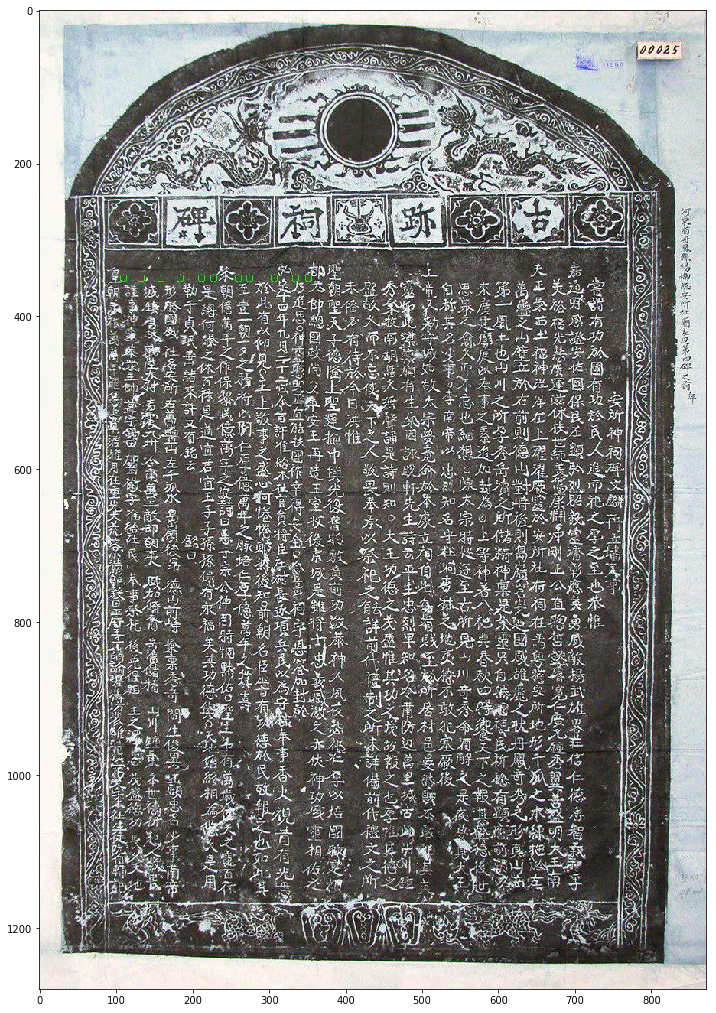

In [17]:
plt.imshow(im1cp)

We can see that they are not perfectly situated between the columns of the image. 

Let's slice the image on these points

In [18]:
sliceList = [sliceOnPoint(im1, p, 
                          colSlice=True, 
                          isUpTo=False,
                         thresh=5)[0] for p in plist]


In [19]:
sl1,sl2,sl3,sl4,sl5,sl6,sl7,sl8,sl9,sl10,sl11 = sliceList

Let's see some of those slices

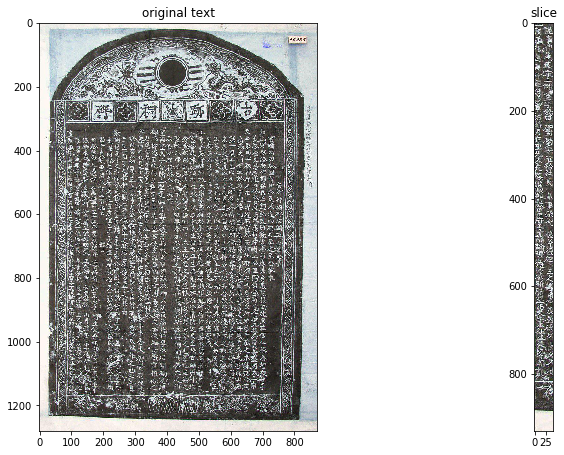

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("original text")
ax1.imshow(im1)

ax2.set_title('slice')
ax2.imshow(sl1)

plt.show()

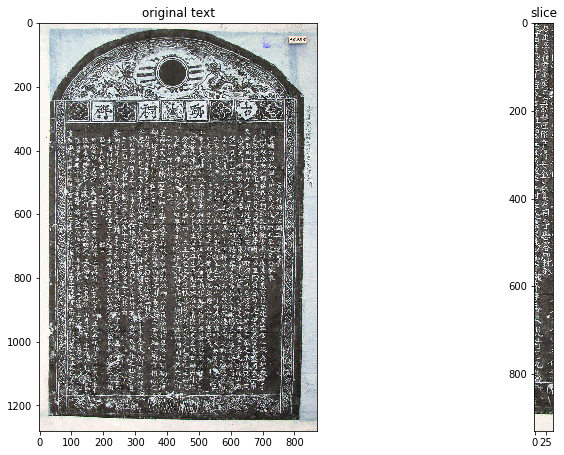

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("original text")
ax1.imshow(im1)

ax2.set_title('slice')
ax2.imshow(sl10)

plt.show()

Let's mark those slices with our marker

In [22]:
markedList = [mark_column(s, mark_color=[0,255,0])[0] for s in sliceList]

Let's see those marks in action

In [23]:
m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11 = markedList

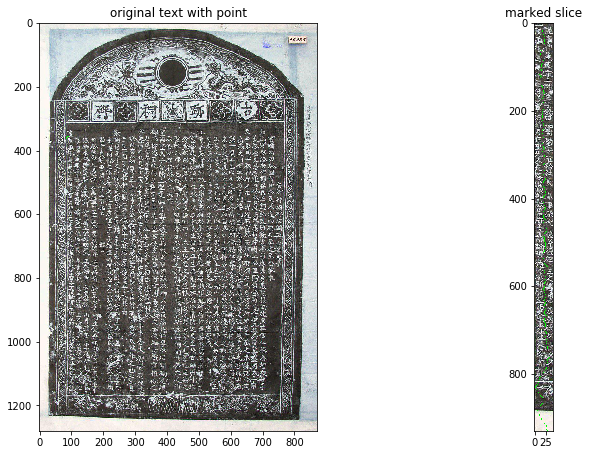

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("original text with point")
im1cp = im1.copy()
c1 = p1[1], p1[0]
im1cp = cv2.circle(im1cp, c1, 5, (0,255,0))
ax1.imshow(im1cp)

ax2.set_title('marked slice')
ax2.imshow(m1)

plt.show()

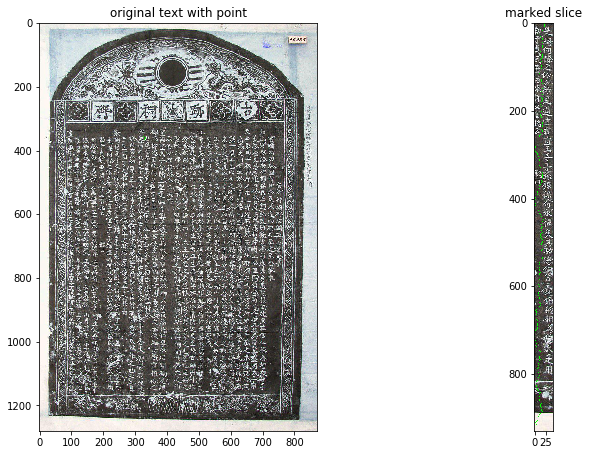

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7.5))
ax1.set_title("original text with point")
ax1.imshow(im1)
im1cp = im1.copy()
c = p5[1], p5[0]
im1cp = cv2.circle(im1cp, c, 5, (0,255,0))
ax1.imshow(im1cp)

ax2.set_title('marked slice')
ax2.imshow(m5)

plt.show()

Once you have marked your slices the segmentation of the text to columns/lines, simply means taking slices of the image between markers.

Now in order to obtain the column, we need to do the following steps:

- Add marks back to the original image
- Get coordinates of the marks from the original image
- Slice the area that is between the coordinates of the marks

Now adding marks back to the image is not really necessary, since earlier we had conserved two important things:

- slice coordinates in the original image
- masks with the mark that have the same size as the slices

So we can create a mask of the original image, and use the same function for adding the slice back to the image to add mark masks to the image mask. Then we can proceed with the other steps.

Let's see how these work out for two points: p2 and p3

In [26]:
im1cp = im1.copy()
# Slicing on point
slice1 = sliceOnPoint(im1cp, p2, thresh=1)
sl1 = slice1[0]
ba1 = slice1[1]
    
# Slicing the second point
slice2 = sliceOnPoint(im1cp, p3, thresh=1)
sl2 = slice2[0]
ba2 = slice2[1]

# getting marks
m1, mask1 = mark_column(sl1, mark_color=[0,255,0])
m2, mask2 = mark_column(sl2, mark_color=[0,255,0])

# adding marked masks back to the image mask
maskImage = np.zeros_like(im1cp, dtype=np.bool)

maskImage1 = addPointSlice2Image(maskImage, p2, ba1, mask1, 
                                 colSlice=True, isUpTo=False)

# same for the second mark
maskImage2 = addPointSlice2Image(maskImage, p3, ba2, mask2, 
                                 colSlice=True, isUpTo=False)


Let's see how we can obtain the coordinates of the marked array from the mask:

In [27]:
def getMarkCoordinates(markedMask: np.ndarray([], dtype=np.bool)):
    "Get marked coordinates from the mask"
    indexArray = markedMask.nonzero()
    indexArray = np.array(indexArray)
    indexArray = indexArray.T
    # indexArray[0] == [rowPosition, colPosition, colorPosition]
    return indexArray

In [28]:
# obtaining mark coordinates from image mask
m1index = getMarkCoordinates(maskImage1)
m2index = getMarkCoordinates(maskImage2)

The returned index array contains the row, and column position of the mark in the original image. 

Now what we need is to slice the image using these coordinates obtained from 2 marks depending on the type of slice, ie. row or column.

In [29]:
def placePointsOnMask(row1: int,
                      row2: int,
                      col1: int,
                      col2: int,
                      mask: np.ndarray([], dtype=np.uint8),
                      img: np.ndarray([], dtype=np.uint8),
                      colSlice: bool):
    "Place points on the mask by comparing row and col position"
    if colSlice is True:
        # if column segmentation rows should be
        # equal if not cols should be equal
        if row1 == row2:
            if col1 < col2:
                mask[row1, col1:col2, :] = img[row1, col1:col2, :]
            elif col2 < col1:
                mask[row1, col2:col1, :] = img[row1, col2:col1, :]
            elif col2 == col1:
                mask[row1, col2, :] = img[row1, col2, :]
    else:
        if col1 == col2:
            if row1 < row2:
                mask[row1:row2, col1, :] = img[row1:row2, col1, :]
            elif row2 < row1:
                mask[row2:row1, col1, :] = img[row2:row1, col1, :]
            elif row2 == row1:
                mask[row2, col1, :] = img[row2, col1, :]
    return mask
                

def sliceImageFromSameSizeMarks(img: np.ndarray([], dtype=np.uint8),
                                markIndex1: np.ndarray([], dtype=np.int32),
                                markIndex2: np.ndarray([], dtype=np.int32),
                                colSlice=True):
        "Slice image from same size marks"
        mask = np.zeros_like(img, dtype=np.uint8)
        markrow1 = markIndex1.shape[0]
        for indxr in range(markrow1):
            row1, col1, color1 = markIndex1[indxr]
            row2, col2, color2 = markIndex2[indxr]

            # check if the slice is rowwise
            if colSlice is True:
                # if column segmentation rows should be
                # equal if not cols should be equal
                if row1 != row2:
                    continue
                mask = placePointsOnMask(row1, row2,
                                        col1, col2,
                                        mask, img,
                                        colSlice)
            else:
                if col1 != col2:
                    continue
                mask = placePointsOnMask(row1, row2,
                                        col1, col2,
                                        mask, img,
                                        colSlice)
        return mask

def sliceImageFromDifferentSizeMarks(img: np.ndarray([], dtype=np.uint8),
                                     markIndex1: np.ndarray([], dtype=np.int32),
                                     markIndex2: np.ndarray([], dtype=np.int32),
                                     colSlice=True):
    "Slice Image with different size mark indices"
    mask = np.zeros_like(img, dtype=np.uint8)
    indexrow1 = markIndex1.shape[0]
    indexrow2 = markIndex2.shape[0]

    # iterate over the rows of index
    for indxr1 in range(indexrow1):
        for indxr2 in range(indexrow2):

            row1, col1, color1 = markIndex1[indxr1]
            row2, col2, color2 = markIndex2[indxr2]

            # check if the slice is rowwise
            if colSlice is True:
                # if column segmentation rows should be
                # equal if not cols should be equal
                if row1 != row2:
                    continue
                mask[row1, col1:col2, :] = img[row1, col1:col2, :]
            else:
                if col1 != col2:
                    continue
                mask[row1:row2, col1, :] = img[row1:row2, col1, :]

    return mask

def sliceImageWithMarks(img: np.ndarray([], dtype=np.uint8),
                        markIndex1: np.ndarray([], dtype=np.int32),
                        markIndex2: np.ndarray([], dtype=np.int32),
                        colSlice=True):
    "Slice the image using marks"
        
    # markrow1 = markIndex1.shape[0]
    # markrow2 = markIndex2.shape[0]
    markrow1 = markIndex1[-1][0]  # should be the last row
    markrow2 = markIndex2[-1][0]  # should be the last row

    markcol1 = markIndex1[-1][1]  # should be the last col
    markcol2 = markIndex2[-1][1]  # should be the last col

    if colSlice is True:
        assert markrow1 == markrow2, "Expected same row shape"\
            "but got: {0}, {1}".format(
                markIndex1.shape,
                markIndex2.shape
            )
    elif colSlice is False:
        assert markcol1 == markcol2, "Expected same col shape"\
            " but got: {0}, {1}".format(
                markIndex1.shape,
                markIndex2.shape
            )

    # make sure marks come from same image
    # or at least image with same size
    indexrow1 = markIndex1.shape[0]
    indexrow2 = markIndex2.shape[0]

    if indexrow1 == indexrow2:
        mask = sliceImageFromSameSizeMarks(img=img,
                                                markIndex1=markIndex1,
                                                markIndex2=markIndex2,
                                                colSlice=colSlice)
    else:
        mask = sliceImageFromDifferentSizeMarks(img=img,
                                                     markIndex1=markIndex1,
                                                     markIndex2=markIndex2,
                                                     colSlice=colSlice)
    return mask

Let's see the result of this slicing

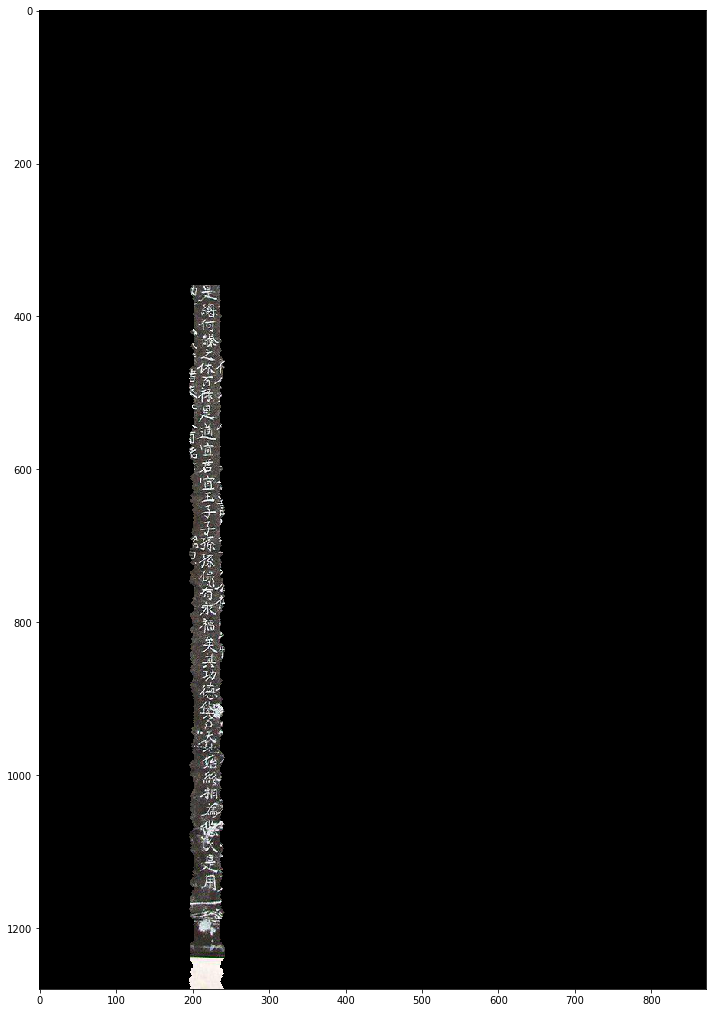

In [30]:
im1mask = sliceImageWithMarks(im1, m1index, m2index)
plt.imshow(im1mask)

It would be great if can simply crop the empty space

In [31]:
def crop_zeros(img: np.ndarray([], dtype=np.uint8)):
    "Crop out zeros from image sides"
    img_cp = img.copy()
    #
    image_col = img_cp.shape[1]
    image_row = img_cp.shape[0]
    #
    delete_list = []
    for col in range(image_col):
        if np.sum(img_cp[:, col], dtype="uint32") == 0:
            delete_list.append(col)
            #
    #
    img_cp = np.delete(arr=img_cp,
                       obj=delete_list,
                       axis=1)
    #
    delete_list = []
    #
    for row in range(image_row):
        if np.sum(img_cp[row, :], dtype="int32") == 0:
            delete_list.append(row)
    #
    img_cp = np.delete(arr=img_cp,
                       obj=delete_list,
                       axis=0)
    #
    return img_cp

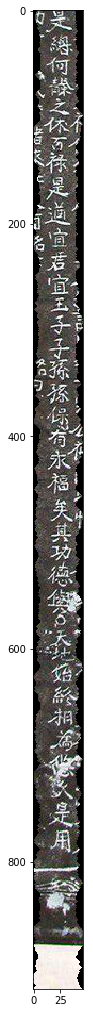

In [32]:
im1col = crop_zeros(im1mask)
plt.imshow(im1col)

Let's regroup all that under a function.

In [33]:
def getSegmentFromPoints(img, 
                         point1, 
                         point2, 
                         colSlice=True,
                         isUpTo=False, 
                         thresh=10,
                         mark_color=[0,255,0]):
    "Get column from given points and the direction"
    # check whether points are consecutive
    imcp = img.copy()
    if colSlice is True:
        p1Col = point1[1]
        p2Col = point2[1]
        assert p2Col >= p1Col
    else:
        p1Row = point1[0]
        p2Row = point2[0]
        assert p2Row >= p1Row
    
    # Slicing on point
    slice1 = sliceOnPoint(imcp, point1, thresh=thresh)
    sl1 = slice1[0]
    ba1 = slice1[1]
    
    # Slicing the second point
    slice2 = sliceOnPoint(imcp, point2, thresh=thresh)
    sl2 = slice2[0]
    ba2 = slice2[1]
    
    # getting marks
    m1, mask1 = mark_column(sl1, mark_color=mark_color)
    m2, mask2 = mark_column(sl2, mark_color=mark_color)
    
    # adding marked masks back to the image mask
    maskImage = np.zeros_like(imcp, dtype=np.bool)
    maskImage1 = addPointSlice2Image(maskImage, point1, 
                                     ba1, mask1,
                                     colSlice=colSlice,
                                     isUpTo=isUpTo)
    
    # obtaining mark coordinates from image mask
    m1index = getMarkCoordinates(maskImage1)
    
    # same for the second mark
    maskImage2 = addPointSlice2Image(maskImage, point2, ba2, mask2, 
                                     colSlice=colSlice, isUpTo=isUpTo)
    m2index = getMarkCoordinates(maskImage2)
    im1mask = sliceImageWithMarks(imcp, m1index, m2index, 
                                  colSlice=colSlice)
    im1mask = crop_zeros(im1mask)
    return im1mask

In [34]:
testim = getSegmentFromPoints(im1, point1=p2, point2=p3, thresh=1)

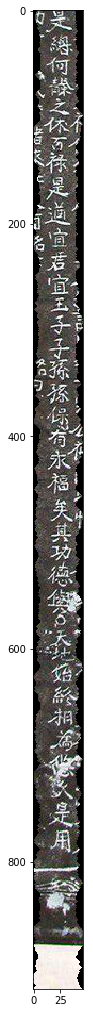

In [35]:
plt.imshow(testim)

Wouldn't it be great if we can simply give a list of points and a direction to the function and let the algorithm segment the page ?

Let's see if we can do that:

In [36]:
def makePairsFromPoints(plist: [], 
                        direction: str):
    'Make point pairs after sorting point list with given direction'
    if (direction != 'down' and 
        direction != 'up' and 
        direction != 'left' and 
        direction != 'right'):
        raise ValueError('unknown direction')
        
    if direction == 'down' or direction == 'up':
        plist.sort(key=lambda p: p[0])
    else:
        plist.sort(key=lambda p: p[1])
    
    pairs = []
    for i in range(len(plist)):
        if i+1 < len(plist):
            p1 = plist[i]
            p2 = plist[i+1]
            pairs.append((p1, p2))
    return pairs

def segmentPageWithPoints(img: np.ndarray([], dtype=np.uint8),
                          plist: [],
                          direction='down',  # allowed values down/up/left/right
                          mark_color=[0,255,0],
                          thresh=10
                         ):
    assert thresh >= 0 and thresh <= 100
    
    if (direction != 'down' and 
        direction != 'up' and 
        direction != 'left' and 
        direction != 'right'):
        raise ValueError('unknown direction')
    #
    if direction == 'down':
        colSlice = True
        isUpTo = False
    elif direction == 'up':
        colSlice = True
        isUpTo = True
    elif direction == 'right':
        colSlice = False
        isUpTo = False
    elif direction == 'left':
        colSlice = False
        isUpTo = True
    #
    # let's make the point pairs
    pairs = makePairsFromPoints(plist, direction)
    segments = [
        getSegmentFromPoints(img, 
                             colSlice=colSlice,
                             isUpTo=isUpTo,
                             thresh=thresh,
                             mark_color=mark_color,
                             point1=pair[0],
                             point2=pair[1])
        for pair in pairs
    ]
    return segments

In [37]:
colSegments = segmentPageWithPoints(im1, 
                                    plist=plist, 
                                    direction='down',
                                    thresh=1)

In [38]:
col1, col2, col3, col4, col5, col6, col7, col8, col9, col10 = colSegments
len(colSegments)

10

Let's see our segments

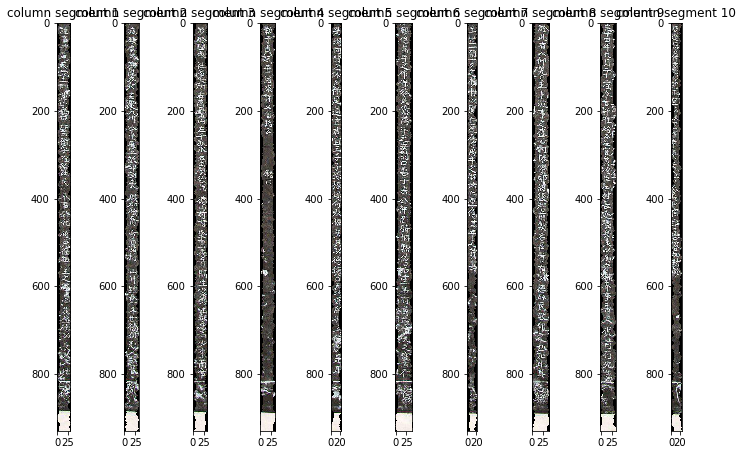

In [39]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(1, 10, figsize=(12, 7.5))

ax1.set_title('column segment 1')
ax1.imshow(col1)

ax2.set_title("column segment 2")
ax2.imshow(col2)

ax3.set_title('column segment 3')
ax3.imshow(col3)

ax4.set_title('column segment 4')
ax4.imshow(col4)

ax5.set_title('column segment 5')
ax5.imshow(col5)

ax6.set_title('column segment 6')
ax6.imshow(col6)

ax7.set_title('column segment 7')
ax7.imshow(col7)


ax8.set_title('column segment 8')
ax8.imshow(col8)


ax9.set_title('column segment 9')
ax9.imshow(col9)


ax10.set_title('column segment 10')
ax10.imshow(col10)


plt.show()

Here are the original points

In [ ]:
im1cp = im1.copy()
for p in plist:
    cent = p[1], p[0]
    im1cp = cv2.circle(im1cp, cent, 5, (0,255,0))
plt.imshow(im1cp)

It is evident that the segmentation was not perfect, given the location of points.

But for the points that are selected with one column distance, the segmentation algorithm effectively provided the column in between.